# Optimizing the KSD

In [1]:
from jax import config
config.update("jax_debug_nans", True)
# config.update("jax_disable_jit", True)

import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning/")
from functools import partial
from itertools import product

from tqdm import tqdm
import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp
import jax
import pandas as pd
import haiku as hk
from jax.experimental import optimizers

import config

import utils
import metrics
import time
import plot
import stein
import kernels
import distributions
import nets
import kernel_learning

from jax.experimental import optimizers

key = random.PRNGKey(0)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
@partial(jit, static_argnums=1)
def get_sd(samples, fun):
    return stein.stein_discrepancy(samples, target.logpdf, fun)

def get_ksds(kernel):
    """Return 100 ksds between prop and target"""
    @jit
    def compute_ksd(samples):
        return stein.ksd_squared_u(samples, target.logpdf, kernel)
    ksds_squared = []
    for _ in tqdm(range(100)):
        samples = proposal.sample(400)
        ksds_squared.append(compute_ksd(samples))
    ksds = ksds_squared
    return ksds

# Parameters

/home/lauro/code/msc-thesis/svgd/kernel_learning/plot.py:200: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  return ax.pcolormesh(*meshgrid, **kwargs)


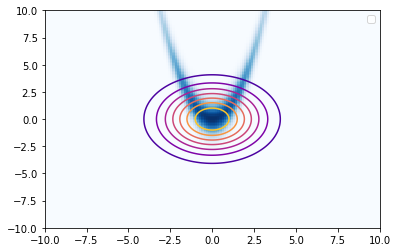

In [3]:
setup = distributions.banana_proposal
target, proposal = setup.get()
sizes = [32, 32, 2]
learning_rate = 0.05
lambda_reg=1
scaling_parameter=True
std_normalize=False
sample_every=True

setup.plot(lims=(-10, 10))

# Train

In [4]:
learner = kernel_learning.KernelLearner(key,
                                        target,
                                        sizes,
                                        kernels.get_rbf_kernel(1),
                                        learning_rate,
                                        lambda_reg=lambda_reg,
                                        scaling_parameter=scaling_parameter,
                                        std_normalize=std_normalize)

kernel = learner.get_kernel(learner.get_params())
ksds_pre = get_ksds(kernel)

100%|██████████| 100/100 [00:07<00:00, 13.98it/s]


In [5]:
print("Training kernel to optimize KSD...")

if sample_every:
    learner.train(samples=None, n_steps=350, proposal=proposal, batch_size=400)
else:
    samples = proposal.sample(400)
    learner.train(samples, n_steps=100)

  0%|          | 0/350 [00:00<?, ?it/s]

Training kernel to optimize KSD...


100%|██████████| 350/350 [03:22<00:00,  1.73it/s]



# Plot result

In [24]:
ksds_post = get_ksds(learner.get_kernel(learner.get_params()))

inducing_samples = proposal.sample(500)
learned_stein_gradient = learner.get_phistar(learner.get_params(), inducing_samples)
def kl_gradient(x):
    return grad(lambda x: target.logpdf(x) - proposal.logpdf(x))(x)
rbf_stein_gradient = stein.get_phistar(kernels.get_rbf_kernel(1), target.logpdf, inducing_samples)

def l2_norm(fun, key):
    def fun_norm(x): return np.linalg.norm(fun(x))**2
    s = proposal.sample(10_000, key)
    return np.mean(vmap(fun_norm)(s))

def rescale_kl_gradient(key, kl_grad: callable):
    keya, keyb = random.split(key)
    m_learned = l2_norm(learned_stein_gradient, keya)
    m_opt = l2_norm(kl_grad, keyb)
    def kl_gradient_rescaled(x):
        return np.sqrt(m_learned / m_opt) * kl_grad(x)
    return kl_gradient_rescaled

if not scaling_parameter:
    rescaled_kl_gradient = rescale_kl_gradient(key, kl_gradient)
    rescaled_rbf_stein_gradient = rescale_kl_gradient(key, rbf_stein_gradient)
elif lambda_reg > 0:
    def rescaled_kl_gradient(x):
        div = 2*learner.lambda_reg
        return kl_gradient(x)/div
    rescaled_rbf_stein_gradient = rescale_kl_gradient(key, rbf_stein_gradient)


# compute optimal KSD
sds = []
for _ in range(100):
    samples = proposal.sample(400)
    sds.append(get_sd(samples, rescaled_kl_gradient))
    
# compute rbf KSD:
rbf_ksds = []
for _ in range(100):
    samples = proposal.sample(400)
    rbf_ksds.append(get_sd(samples, rescaled_rbf_stein_gradient))

100%|██████████| 100/100 [00:06<00:00, 15.97it/s]


Plot results:


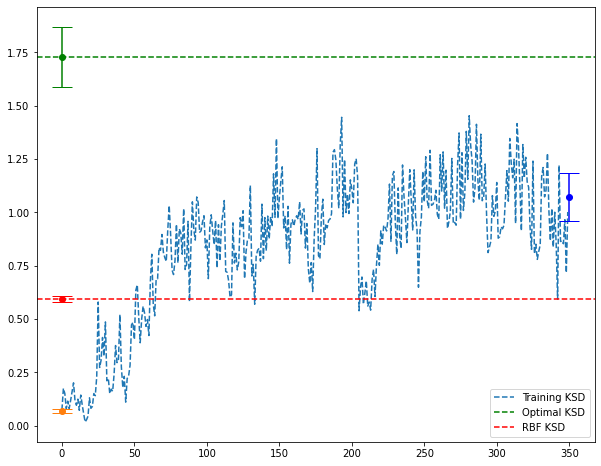

In [25]:
print("Plot results:")

rundata = learner.rundata
fig, ax = plt.subplots(figsize=[10,8])
# plt.plot(rundata["training_ksd"], "--", label="Training KSD")
plt.plot(rundata["ksd_squared"], "--", label="Training KSD")
plt.errorbar(x=0, y=onp.mean(ksds_pre), yerr=onp.std(ksds_pre), fmt="o", capsize=10)
plt.errorbar(x=len(rundata["loss"]), y=onp.mean(ksds_post), yerr=onp.std(ksds_post), fmt="o", capsize=10, color="b")
plt.errorbar(x=0, y=onp.mean(sds), yerr=onp.std(sds), fmt="o", capsize=10, color="green")
plt.axhline(y=onp.mean(sds), linestyle="--", label="Optimal KSD", color="green")
plt.axhline(y=onp.mean(rbf_ksds), linestyle="--", label="RBF KSD", color="red")
plt.errorbar(x=0, y=onp.mean(rbf_ksds), yerr=onp.std(rbf_ksds), fmt="o", capsize=10, color="red")
plt.legend()
# plt.ylim((-1, 0.5))
# plt.yscale("log")

In [8]:
concat_ratio = utils.dict_concatenate(rundata["update-to-weight-ratio"])
concat_ratio = onp.array([d["w"] for d in concat_ratio.values()])

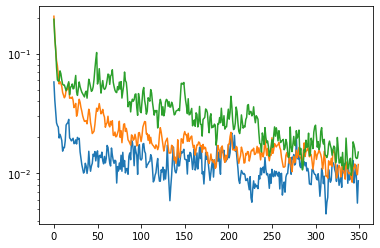

In [9]:
plt.plot(np.rollaxis(concat_ratio, 1))
plt.yscale("log")

## learned stein gradient

In [10]:
l2_norm(learned_stein_gradient, key)

DeviceArray(0.18062831, dtype=float32)

In [11]:
l2_norm(rescaled_kl_gradient, key)

DeviceArray(0.18325184, dtype=float32)

In [12]:
# _ = plt.hist(zz.flatten(), bins=50)

/home/lauro/code/msc-thesis/svgd/kernel_learning/plot.py:200: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  return ax.pcolormesh(*meshgrid, **kwargs)


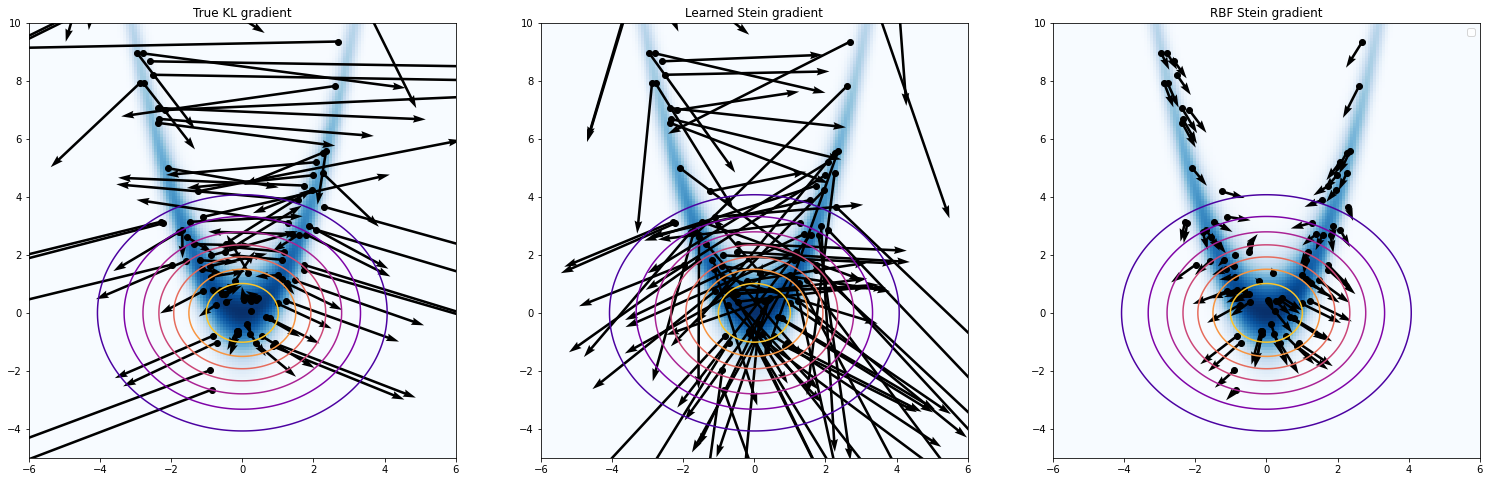

In [13]:
fig, axs = plt.subplots(1, 3, figsize=[26,8])
axs = axs.flatten()
def log_diff(x):
    return (target.logpdf(x) - proposal.logpdf(x)) / div

samples = None
samples = proposal.sample(100)
xlims = [-6, 6]
ylims = [-5, 10]
fields = (rescaled_kl_gradient, learned_stein_gradient, rescaled_rbf_stein_gradient)
scales = (1, 1, 1)
titles = ("True KL gradient", "Learned Stein gradient", "RBF Stein gradient")
for ax, vector_field, scale, title in zip(axs, fields, scales, titles):
#     ax.pcolormesh(xx, yy, zz, vmin=-50, vmax=1, cmap="Blues")
    setup.plot(ax=ax, xlims=xlims, ylims=ylims)
    plot.quiverplot(vector_field, samples=samples, num_gridpoints=10, scale=scale, xlims=xlims, ylims=ylims, ax=ax)
    ax.set_ylim(ylims)
    ax.set_title(title)

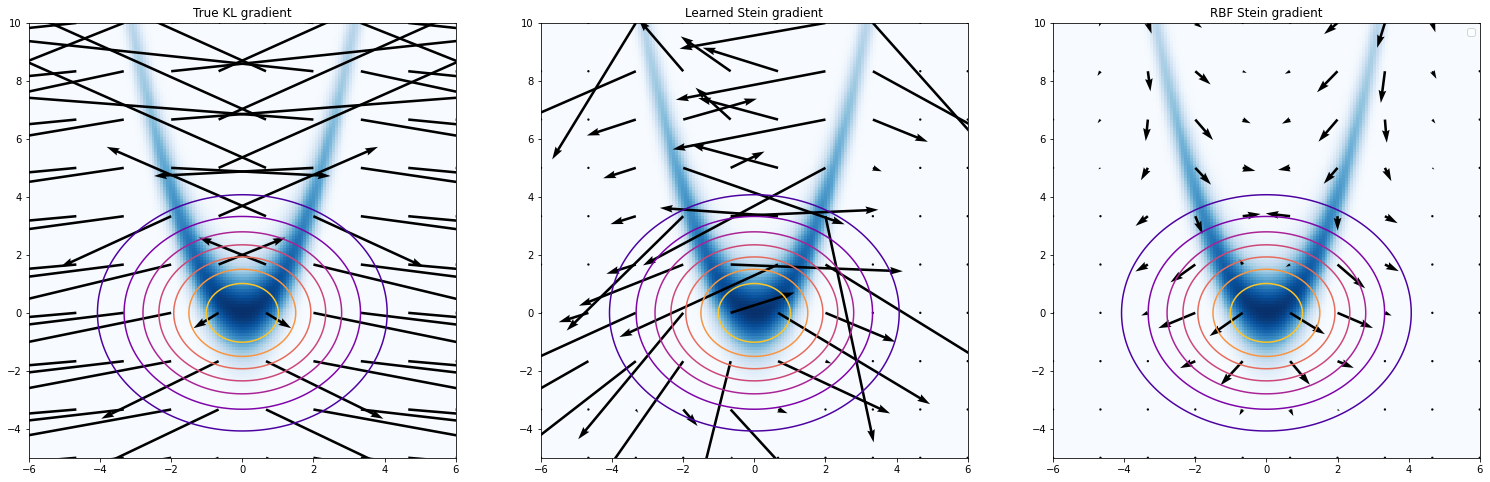

In [14]:
fig, axs = plt.subplots(1, 3, figsize=[26,8])
axs = axs.flatten()
def log_diff(x):
    return (target.logpdf(x) - proposal.logpdf(x)) / div

samples = None
# samples = proposal.sample(100)
xlims = [-6, 6]
ylims = [-5, 10]
fields = (rescaled_kl_gradient, learned_stein_gradient, rescaled_rbf_stein_gradient)
scales = (1, 1, 1)
titles = ("True KL gradient", "Learned Stein gradient", "RBF Stein gradient")
for ax, vector_field, scale, title in zip(axs, fields, scales, titles):
#     ax.pcolormesh(xx, yy, zz, vmin=-50, vmax=1, cmap="Blues")
    setup.plot(ax=ax, xlims=xlims, ylims=ylims)
    plot.quiverplot(vector_field, samples=samples, num_gridpoints=10, scale=scale, xlims=xlims, ylims=ylims, ax=ax)
    ax.set_ylim(ylims)
    ax.set_title(title)

# plot learned kernel

In [15]:
params = learner.opt.get_params(learner.optimizer_state)
learned_kernel = learner.get_kernel(params)

In [16]:
s = proposal.sample(100)
learned_kernel(s[4], s[10])

DeviceArray(0.00192834, dtype=float32)

In [17]:
bandwidth = rundata["bandwidth"][-1]
# bandwidth

In [18]:
levels=[2.5]

/home/lauro/code/msc-thesis/svgd/kernel_learning/plot.py:198: UserWarning: No contour levels were found within the data range.
  return ax.contour(*meshgrid, **kwargs)


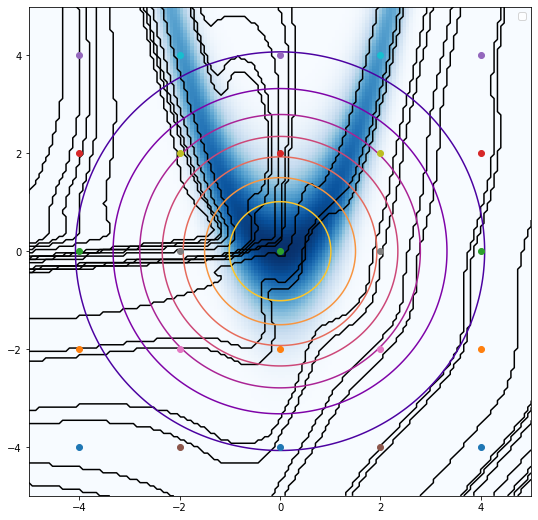

In [19]:
fig, ax = plt.subplots(figsize=[9,9])

gridpoints = [-4, -2, 0, 2, 4]
# gridpoints = [0]
inducing_points = [np.array([a,b]) for a, b in product(gridpoints, gridpoints)]
for x in inducing_points:
    @jit
    def kernfunx(x_): return learned_kernel(x, x_)
    plt.plot(x[0], x[1], "o")
    c = plot.plot_fun_2d(kernfunx, lims=(-5, 5), ax=ax, type="contour", levels=0, colors="black")

# plot.plot_fun_2d(proposal.pdf)
setup.plot()

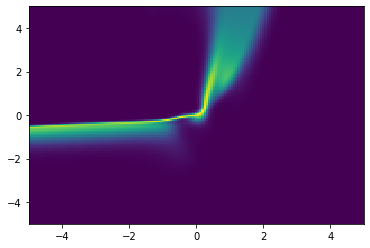

In [20]:
x = np.array([0,0])
def kernfunx(x_): return learned_kernel(x, x_)
plot.plot_fun_2d(kernfunx)